In [3]:
import os
import json
import albumentations as A
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from utils.dataset import load_mask, load_bboxes, load_classIdxMap, load_stafflines
from utils.staffline_variations import default_stafflines, staffline_interruptions, thickness_variations, y_variations

DATASET_PATH = os.path.join("..", "..", "datasets", "generated")
PNG_PATH = os.path.join(DATASET_PATH, "png")
BBOX_PATH = os.path.join(DATASET_PATH, "bbox")
OUT_DIR = os.path.join(DATASET_PATH, "aug")

with open(os.path.join(DATASET_PATH, "classlist.json")) as file:
    classlist = json.load(file)
    classmap = {c["id"]:c["class"] for c in classlist}

# Morphology

4


'..\\..\\datasets\\generated\\png\\002\\out-0.png'

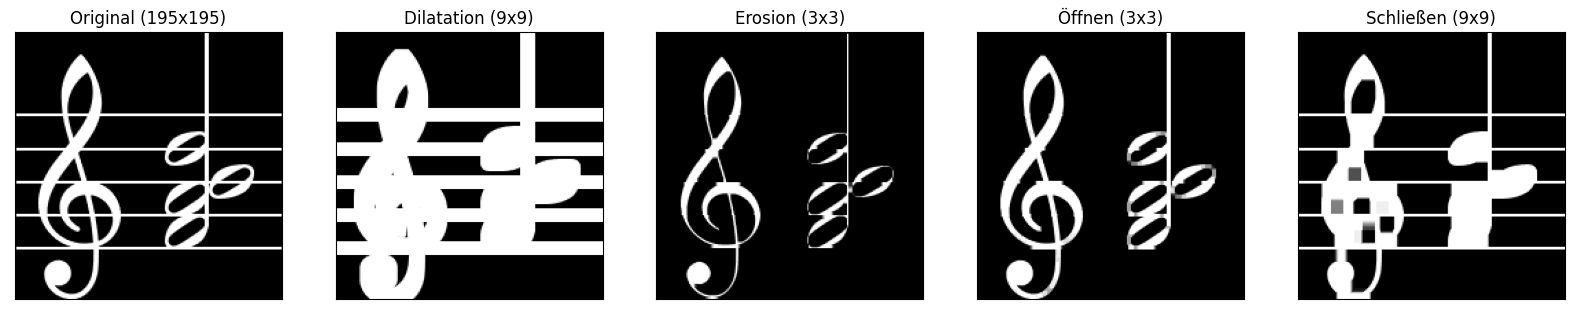

In [94]:
idx = 2
sample_idx = f"{idx:03d}"

orig_img_x = cv2.imread(os.path.join(PNG_PATH, f"{sample_idx}", "out-0.png"))
bboxes = load_bboxes(BBOX_PATH, sample_idx, img_shape=orig_img_x.shape)
systems = [bbox for bbox in bboxes if bbox["type"]=="ClefG"]
# systems = {bbox["id"]: bbox for bbox in bboxes if bbox["type"]=="System"}
print(len(systems))

# grab system
sys_idx = 0
eps = 15
system = systems[sys_idx]
x0 = system["x"] - eps
x1 = x0 + system["width"] + eps + eps
y0 = system["y"] - eps
y1 = y0 + system["height"] + eps + eps

# x1 += 43
sample = 255 - orig_img_x[y0:y1, x0:x1]
# sample[560:, 870:920] = 0

sample = 255 - cv2.imread("plots/morph_base.png")
sample[:, -1] = 0
sample[:, 0] = 0

# apply morph ops
results = [sample]
titles = [f"Original ({sample.shape[0]}x{sample.shape[1]})"]

# dilation
kernel_size = (9, 9)
kernel = np.ones(kernel_size, np.uint8)
res = cv2.dilate(sample, kernel)
results.append(res)
titles.append(f"Dilatation ({kernel_size[0]}x{kernel_size[1]})")

# erosion
kernel_size = (3, 3)
kernel = np.ones(kernel_size, np.uint8)
res = cv2.erode(sample, kernel)
results.append(res)
titles.append(f"Erosion ({kernel_size[0]}x{kernel_size[1]})")

# opening
kernel_size = (3, 3)
kernel = np.ones(kernel_size, np.uint8)
res = cv2.morphologyEx(sample, cv2.MORPH_OPEN, kernel)
results.append(res)
titles.append(f"Öffnen ({kernel_size[0]}x{kernel_size[1]})")

# closing
kernel_size = (9, 9)
kernel = np.ones(kernel_size, np.uint8)
res = cv2.morphologyEx(sample, cv2.MORPH_CLOSE, kernel)
results.append(res)
titles.append(f"Schließen ({kernel_size[0]}x{kernel_size[1]})")

fig, axs = plt.subplots(1, len(results), figsize=(20, 20))
# fig, axs = plt.subplots(len(results), 1, figsize=(20, 20))
for idx, res in enumerate(results):
    vis = res
    # vis = 255 - vis
    axs[idx].imshow(vis)
    axs[idx].get_xaxis().set_visible(False)
    axs[idx].get_yaxis().set_visible(False)
    axs[idx].set_title(titles[idx])
    cv2.imwrite(os.path.join("plots", f"{titles[idx]}.png"), vis)
os.path.join(PNG_PATH, f"{sample_idx}", "out-0.png")

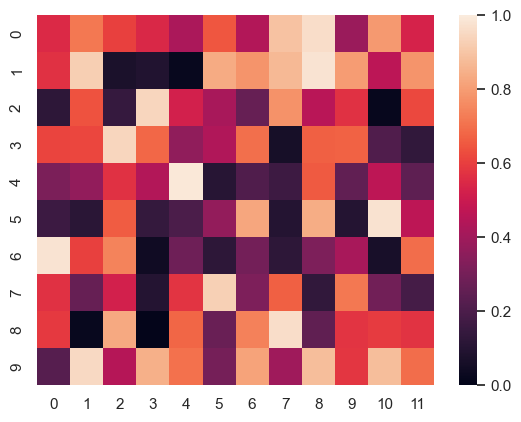

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(0)
sns.set()
uniform_data = np.random.rand(10, 12)
ax = sns.heatmap(uniform_data, vmin=0, vmax=1)
plt.show()

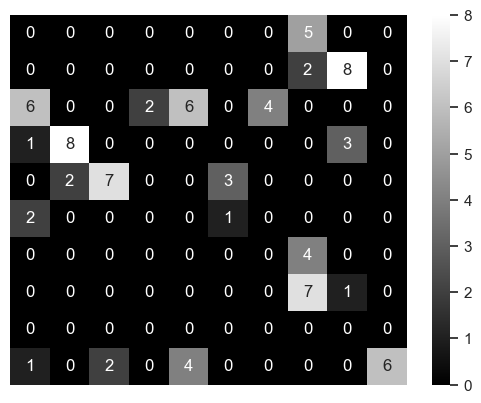

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

results = np.random.randint(0, 9, size=(10, 10))
results *= np.random.randint(0, 2, size=(10, 10))
results *= np.random.randint(0, 2, size=(10, 10))
labels = np.array([f"{value:d}" for value in results.flatten()]).reshape(10, 10)

fig, ax = plt.subplots()
tmp = sns.heatmap(results, annot=labels, fmt="", cmap='gray', ax=ax)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
fig.savefig('plots/sample_values.png', dpi=400)

array([ 0.        ,  0.03921569,  0.15686275,  0.19607843,  0.23529412,
        0.66666667,  0.74509804,  0.82352941,  0.90196078,  0.94117647,
        1.45098039,  1.56862745,  1.68627451,  1.7254902 ,  1.84313725,
        1.92156863,  1.96078431,  2.47058824,  2.66666667,  2.90196078,
        2.98039216,  3.05882353,  3.09803922,  3.25490196,  4.50980392,
        5.05882353,  5.37254902,  5.88235294,  6.07843137,  6.15686275,
        6.23529412,  6.39215686,  6.98039216,  7.09803922,  7.17647059,
        7.60784314,  7.68627451,  7.76470588,  7.80392157,  7.88235294,
        8.        ,  8.23529412,  8.78431373,  8.82352941,  8.98039216,
        9.21568627,  9.25490196,  9.64705882,  9.80392157,  9.84313725,
        9.88235294,  9.92156863, 10.        ])

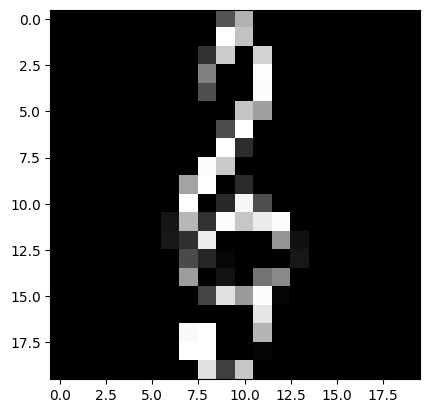

In [28]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

img = 255 - cv2.imread("plots/pixels.png")
img[-1:, :] =  0
img = cv2.resize(img, (20, 20), cv2.INTER_AREA)
# img *= img
plt.imshow(img)
np.unique((img[..., 0] / np.max(img[..., 0])* 10))

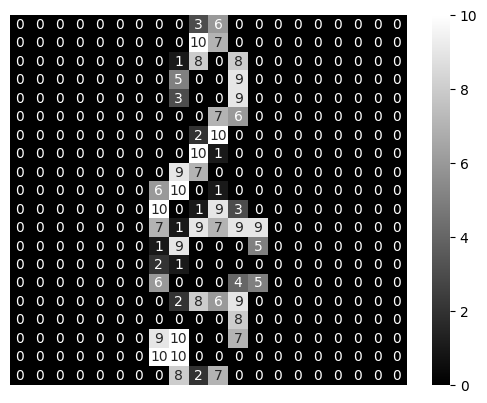

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

results = (img[..., 0] / np.max(img[..., 0])* 10)
results = results.astype(np.uint8)
labels = np.array([f"{value:d}" for value in results.flatten()]).reshape(results.shape)

fig, ax = plt.subplots()
tmp = sns.heatmap(results, annot=labels, fmt="", cmap='gray', ax=ax)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
fig.savefig('plots/sample_values.png', dpi=400)

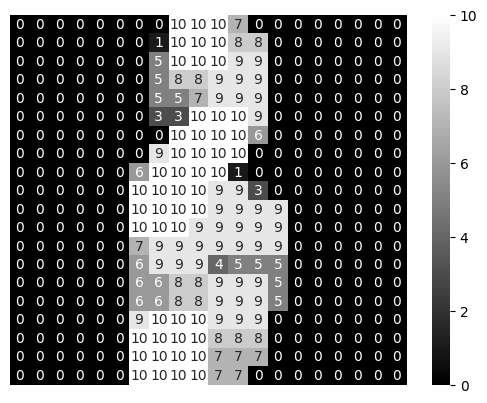

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

kernel = np.ones((3, 3), np.uint8)
results = cv2.dilate(results, kernel)
labels = np.array([f"{value:d}" for value in results.flatten()]).reshape(results.shape)

fig, ax = plt.subplots()
tmp = sns.heatmap(results, annot=labels, fmt="", cmap='gray', ax=ax)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
fig.savefig('plots/sample_values_dil.png', dpi=400)